# Desafío

Determinar el número de ventas diarias  de una bebida en el mes de Febrero del 2022, a partir de los registros 4 años en un local del litoral central.

In [32]:
# librerias básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# librerias ML
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import  mean_squared_error as mse

# librerias estadisticas
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf

# librerias cientificas
from scipy.stats import t


## Problema  1

La fecha de dato `ds` es considerado como index en formato datastamp.

In [33]:
dftrain = pd.read_csv( 'dataset_ts_ventas_train.csv', 
    parse_dates=['ds'],
    infer_datetime_format=True,
    index_col='ds'
)

dftest = pd.read_csv( 'dataset_ts_ventas_test.csv', 
    parse_dates=['ds'],
    infer_datetime_format=True,
    index_col='ds'
)


Información general de las variables.

In [34]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1854 entries, 2017-01-01 to 2022-01-31
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   precio_ref      1854 non-null   float64
 1   unidades_total  1854 non-null   int64  
 2   monto_total     1854 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 57.9 KB


In [35]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28 entries, 2022-02-01 to 2022-02-28
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   precio_ref      28 non-null     float64
 1   unidades_total  28 non-null     int64  
 2   monto_total     28 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 896.0 bytes


In [36]:
dftrain.head()

,precio_ref,unidades_total,monto_total
ds,,,
2017-01-01,990.0,158,142740
2017-01-02,990.0,152,137180
2017-01-03,990.0,125,115390
2017-01-04,990.0,107,98710
2017-01-05,990.0,103,96270


Estadística general de los datos.

In [37]:
dftrain.describe().T

,count,mean,std,min,25%,50%,75%,max
precio_ref,1854.0,1040.471413,66.109625,990.0,990.0,990.0,1100.0,1150.0
unidades_total,1854.0,68.458468,23.897066,7.0,52.0,67.0,83.0,184.0
monto_total,1854.0,67219.677994,22672.280345,6734.0,51750.0,66150.0,80837.5,176273.0


La tabla anterior, muestra un rango amplio de `unidades_total` vendidas al día. Desde un mínimo de 7 a máximo de 184 unidades. Mientras que el `precio_ref` tiene un margen más estable.

<AxesSubplot:xlabel='unidades_total', ylabel='Count'>

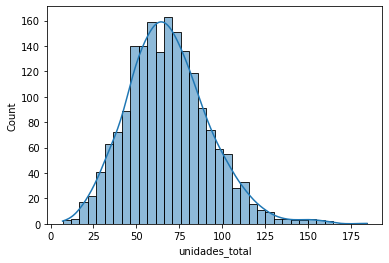

In [38]:
sns.histplot( x='unidades_total', data=dftrain, kde=True )

El gráfico anterior indica que las ventas diarias estan entre las 50 unidades y las 100 unidades. 

<AxesSubplot:xlabel='precio_ref', ylabel='Count'>

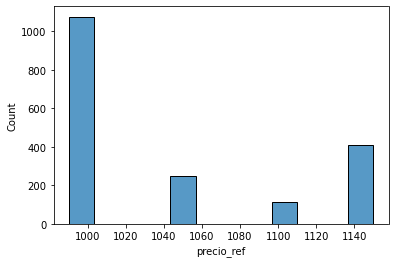

In [39]:
sns.histplot( x='precio_ref', data=dftrain, )

Predomina el valor de 990.

### Análisis de la serie temporal  de las unidades total vendidas. 

In [40]:
def Decompose(df, share_type='unidades_total', samples=250, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot La completa serie de tiempo 
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot La tendencia de la serie de tiempo
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

Aplicando a toda la serie de tiempo una descomposión con período de un año, notamos una tendencia(Trend)  descendente desde aproximadamente el día 800, cercano a los primeros dias de marzo del 2019.

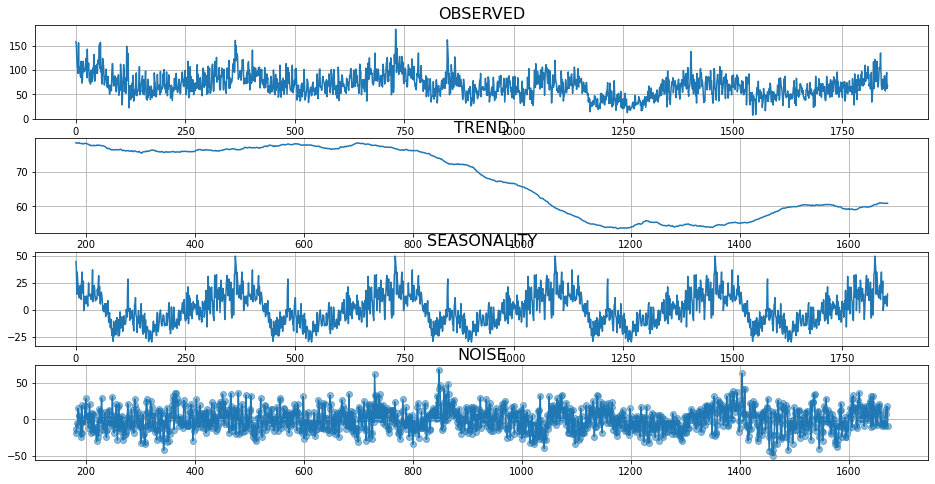

In [41]:
Decompose(dftrain , samples= 'all', period = 365 )


# Problema 2

Aplicando a la serie de tiempo una descomposión de rango de un año y con período de una semana (period 7 días), muestra un ciclo estacional (SEASONALITY) de una semana. 

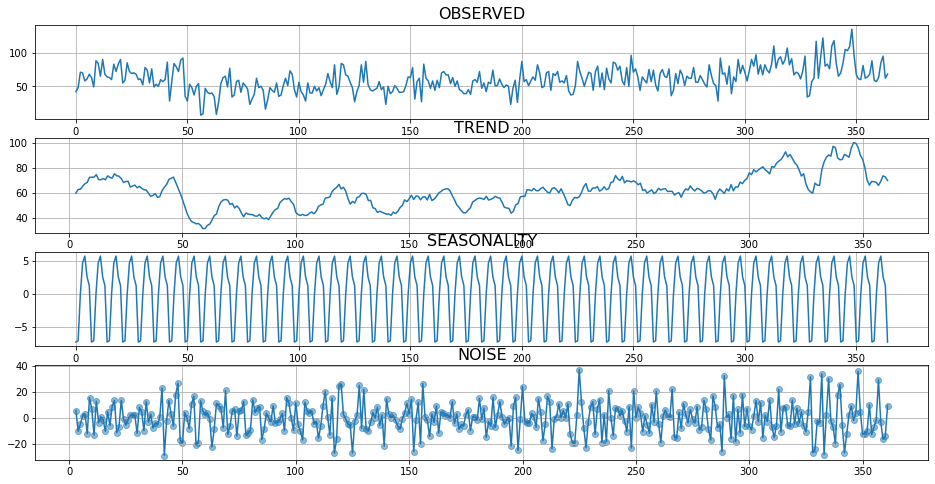

In [42]:
Decompose(dftrain , samples= 365, period = 7 )


### Ventas por día de la semana. 

In [43]:
dftrain['dia_sem'] =  dftrain.index.dayofweek
dftest['dia_sem'] =  dftest.index.dayofweek



In [44]:
dsum =dftrain.groupby( 'dia_sem').sum()
dsum['Day'] =  ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom'] 


<AxesSubplot:xlabel='Day', ylabel='unidades_total'>

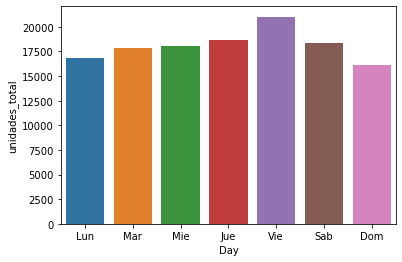

In [45]:
sns.barplot( x=dsum.Day , y=dsum['unidades_total'] ,   )

Por lo anterior, el día de mayor de venta de bebidas corresponde al Viernes y el menor el día Domingo.

# Problema 3

Descomposión  rango de un año y con período de mes (period 30 dìas). Indica una tendencia en alza hacia la época veraniega(350). 

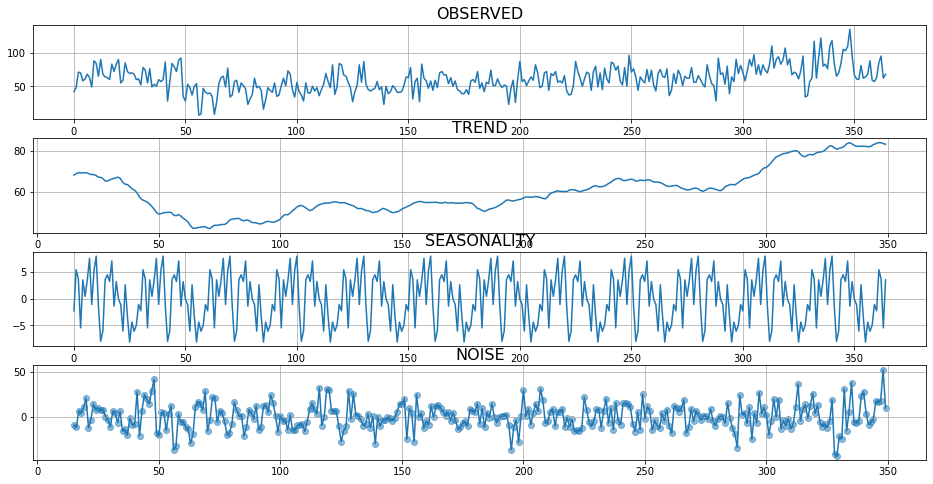

In [46]:
Decompose(dftrain , samples= 365, period = 30 )


# Problema 4

In [47]:
# dataset covid

dfcovid = pd.read_csv( 'covid.csv',
    parse_dates=['Fecha'],
    infer_datetime_format=True,
    index_col='Fecha'
                   )


covid = dfcovid[ ['Casos nuevos con sintomas', 'Casos totales', 'Fallecidos', 'Casos activos']][:'2022-02-28'] 
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2020-03-02 to 2022-02-28
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Casos nuevos con sintomas  729 non-null    float64
 1   Casos totales              729 non-null    float64
 2   Fallecidos                 729 non-null    float64
 3   Casos activos              710 non-null    float64
dtypes: float64(4)
memory usage: 28.5 KB


In [48]:
dftrain.iloc[1170]

precio_ref         1150.0
unidades_total       34.0
monto_total       39100.0
dia_sem               1.0
Name: 2020-03-17 00:00:00, dtype: float64

El primer caso de COVID en Chile ocurre en `2020-03-02`, aproximadamente el dia  1150.

El siguiente gráfico muestra que existe un descenso y la mantención de esté durante alrededor de 200 dias (1200 a 1400), epoca de plena pandemia  en Chile.

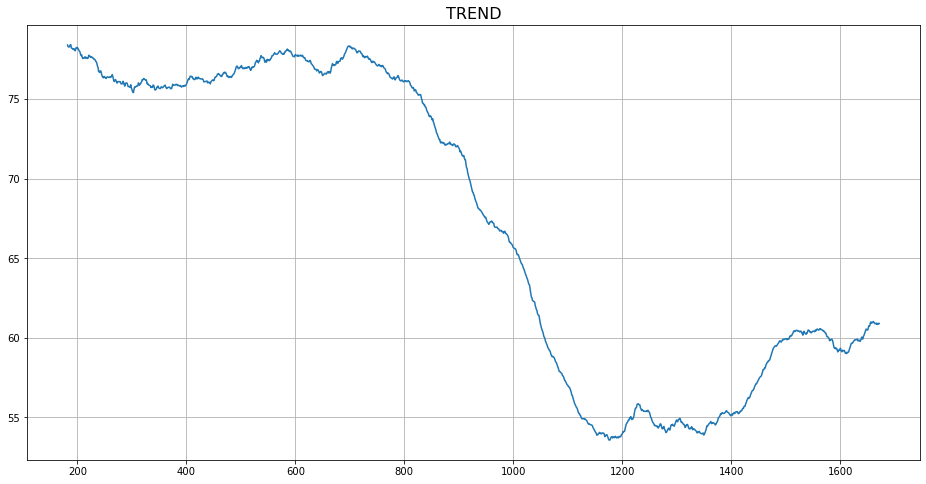

In [49]:
res = seasonal_decompose(dftrain['unidades_total'].values, period=365)
trend = res.trend

   #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
fig, axs = plt.subplots(1, figsize=(16,8))  
axs.set_title('TREND', fontsize=16)

plt.plot(trend)


axs.grid()
    

Unión de datasets `covid` con `dftrain` y `dftest`

In [50]:
# Dividiendo en train y test data.

covidtrain = covid[:'2022-01-31']
covidtest = covid['2022-02-01':]

covidtest.head()



,Casos nuevos con sintomas,Casos totales,Fallecidos,Casos activos
Fecha,,,,
2022-02-01,13374.0,2190561.0,39733.0,113734.0
2022-02-02,19192.0,2221276.0,39742.0,112804.0
2022-02-03,19439.0,2258005.0,39824.0,118427.0
2022-02-04,21103.0,2296712.0,39867.0,125857.0
2022-02-05,20700.0,2335034.0,39930.0,131295.0


In [51]:
# Unión datasets

train = dftrain.join( covidtrain)
train.fillna( 0, inplace=True ) # llenar con ceros valores NA/NAN  

test = dftest.join( covidtest)
test.fillna( 0, inplace=True )


# Problema 5


In [52]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,precio_ref,unidades_total,monto_total,dia_sem,Casos nuevos con sintomas,Casos totales,Fallecidos,Casos activos
precio_ref,1.000000,-0.195588,-0.102041,0.002642,0.062979,0.140769,0.121168,0.079564
unidades_total,-0.195588,1.000000,0.982550,0.023984,-0.276285,-0.160221,-0.161050,-0.279105
monto_total,-0.102041,0.982550,1.000000,0.028703,-0.265144,-0.120417,-0.125419,-0.271222
dia_sem,0.002642,0.023984,0.028703,1.000000,0.044758,-0.001206,-0.001168,0.004080
Casos nuevos con sintomas,0.062979,-0.276285,-0.265144,0.044758,1.000000,0.560904,0.546171,0.915816
Casos totales,0.140769,-0.160221,-0.120417,-0.001206,0.560904,1.000000,0.996547,0.606819
Fallecidos,0.121168,-0.161050,-0.125419,-0.001168,0.546171,0.996547,1.000000,0.600097
Casos activos,0.079564,-0.279105,-0.271222,0.004080,0.915816,0.606819,0.600097,1.000000


El gráfico de correlación nos indica que entre las variables asociadas al COVID, la variable  `Casos activos` es la que afecta en mayor medida las unidades vendidas.

# Problema 6


# Modelo 

In [53]:
modelRF = RandomForestRegressor(random_state = 42)

Xtrain = train.drop( ['unidades_total'], axis =1)
ytrain = train['unidades_total']

Xtest = test.drop( ['unidades_total'], axis =1)
ytest = test['unidades_total']

modelRF.fit( Xtrain , ytrain   )

RandomForestRegressor(random_state=42)

In [54]:
ypred = modelRF.predict( Xtest )

# Problema 7

###  Métrica RMSE

Se utilizara la métrica RMSE ya que esta en las mismas unidades de la variable a predecir.

In [55]:
print( 'RMSE : ', np.sqrt( (  mse(ypred, ytest) )) )

RMSE :  4.651361562480457


Por tanto, tenemos un error aproximado de 4.7, es decir, el valor predicho  difiere del esperado 4.7 eunidades vendidas en promedio. 

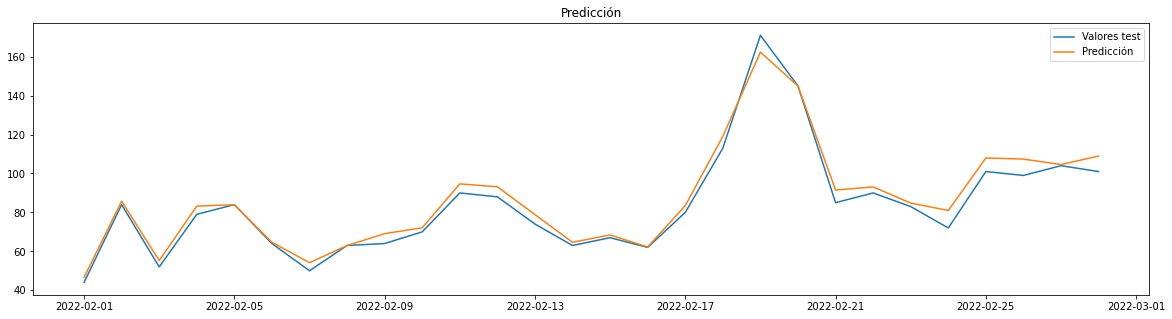

In [56]:
fig, ax = plt.subplots( figsize=(20, 5))

plt.plot( dftest.index , ytest , label='Valores test'  )
plt.plot( dftest.index , ypred , label='Predicción'  )


plt.legend()
plt.title('Predicción')
plt.show()

# Problema 8

Una mejora, seria modelo hibrido, que incluyera un segundo método de pronóstico, con caracteriscas distintas al random forest, y que no provocara un sobreajuste. Otra mejora serìa incorporar el precio de los combustibles, ya que  afecta los costos de transporte de los insumos.